## Подгружаем библиотеки

In [1]:
import happybase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
%matplotlib inline 

## Устанавливаем соединение с БД

In [2]:
connection = happybase.Connection(host='89.208.221.132', port=9090, autoconnect=True)

In [3]:
table = connection.table('student4_2_table')

## Читаем данные из БД

In [4]:
data_df = {}
i=0
for key,data in table.scan():
    data_df[i] = data
    if i<10000:
        i +=1
    else:
        break

In [5]:
i=0
for k in [i for i in data_df.values()]:
    k=list(k.values())[0].decode('utf8').split('b')[0].split(',')
    data_df[i] = k
    i+=1

## Собирем датасет

In [6]:
data_df = pd.DataFrame(data_df.values(),columns=['date','date_block_num','shop_id','item_id','item_price','item_cnt_dayr'])

## Просмотрел данные

In [7]:
data_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_dayr
0,13.01.2013,0,3,11041,349.0,1.0
1,02.01.2013,0,16,9507,149.0,1.0
2,08.01.2013,0,47,15060,399.0,1.0
3,18.01.2013,0,16,21916,149.0,1.0
4,20.01.2013,0,31,11417,499.0,1.0


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 6 columns):
date              10001 non-null object
date_block_num    10001 non-null object
shop_id           10001 non-null object
item_id           10001 non-null object
item_price        10001 non-null object
item_cnt_dayr     10001 non-null object
dtypes: object(6)
memory usage: 468.9+ KB


In [9]:
data_df.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_dayr
count,10001,10001,10001,10001,10001,10001
unique,31,1,44,3631,637,17
top,02.01.2013,0,25,3432,149.0,1.0
freq,558,10001,728,60,1201,9055


## Визуализируем данные

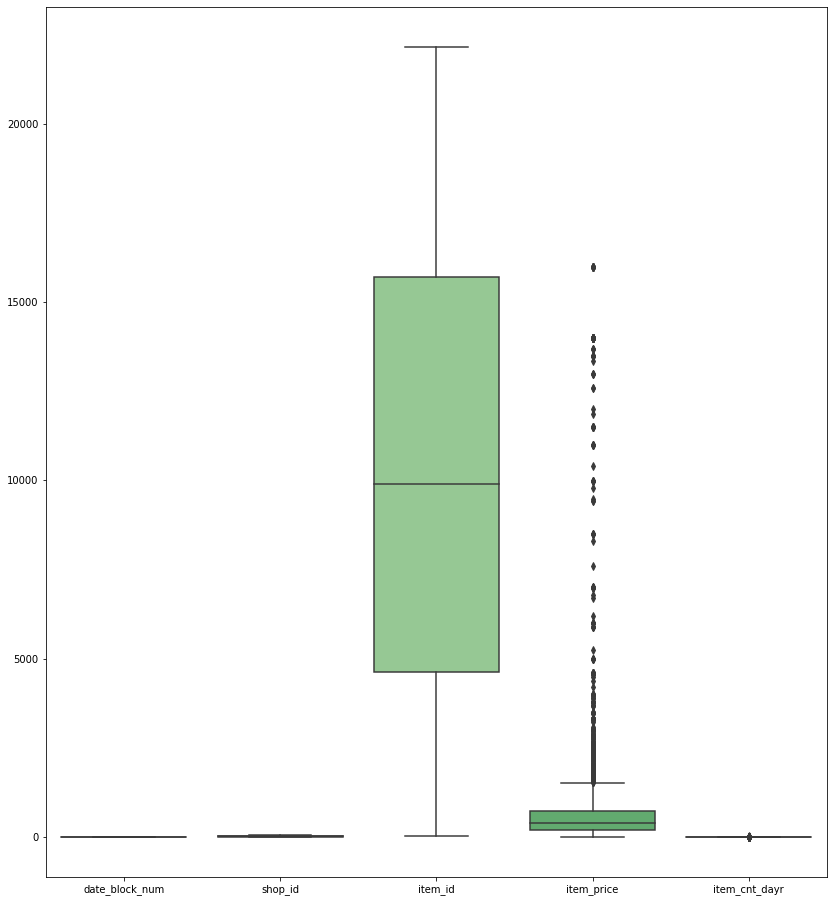

In [10]:
plt.figure(figsize=(14,16))
sns.boxplot(data=data_df, palette=sns.color_palette('Greens'))
plt.show()

## Преобразуем данные

In [11]:
data_df['item_price'] = data_df['item_price'].astype(float)
data_df = data_df.loc[data_df['item_price']>0,:]
data_df['sum_by_shop'] = data_df['item_price'].copy()
for k,i in enumerate(data_df['shop_id']):
    data_df['sum_by_shop'][k] = data_df.loc[data_df['shop_id'] == i,'item_price'].sum()

In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10001 entries, 0 to 10000
Data columns (total 7 columns):
date              10001 non-null object
date_block_num    10001 non-null object
shop_id           10001 non-null object
item_id           10001 non-null object
item_price        10001 non-null float64
item_cnt_dayr     10001 non-null object
sum_by_shop       10001 non-null float64
dtypes: float64(2), object(5)
memory usage: 945.1+ KB


In [13]:
data_df['item_price_quant']=data_df['sum_by_shop'].copy()
quant_list = data_df['sum_by_shop'].quantile([0.25,0.5,0.75,1])
for k,i in enumerate(data_df['sum_by_shop']):
    if i<=quant_list[0.25]:
        data_df['item_price_quant'][k] = 0
    if i<=quant_list[0.5] and i>quant_list[0.25]:
        data_df['item_price_quant'][k] = 1
    if i<=quant_list[0.75] and i>quant_list[0.5]:
        data_df['item_price_quant'][k] = 2
    if i<=quant_list[1] and i>quant_list[0.75]:
        data_df['item_price_quant'][k] = 3


In [14]:
income_by_shop = data_df[['sum_by_shop','item_price_quant']].groupby('item_price_quant').sum()

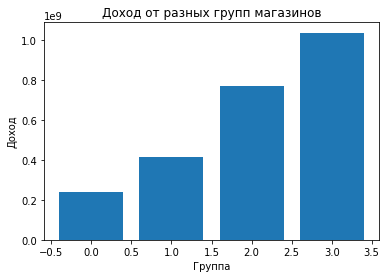

In [15]:
plt.bar(income_by_shop.index,income_by_shop['sum_by_shop'])
plt.title('Доход от разных групп магазинов')
plt.xlabel('Группа')
plt.ylabel('Доход')
plt.show()

## Просмотрел корреляцию

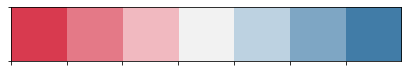

In [16]:
sns.palplot(sns.diverging_palette(8, 240, sep=20, n=7))

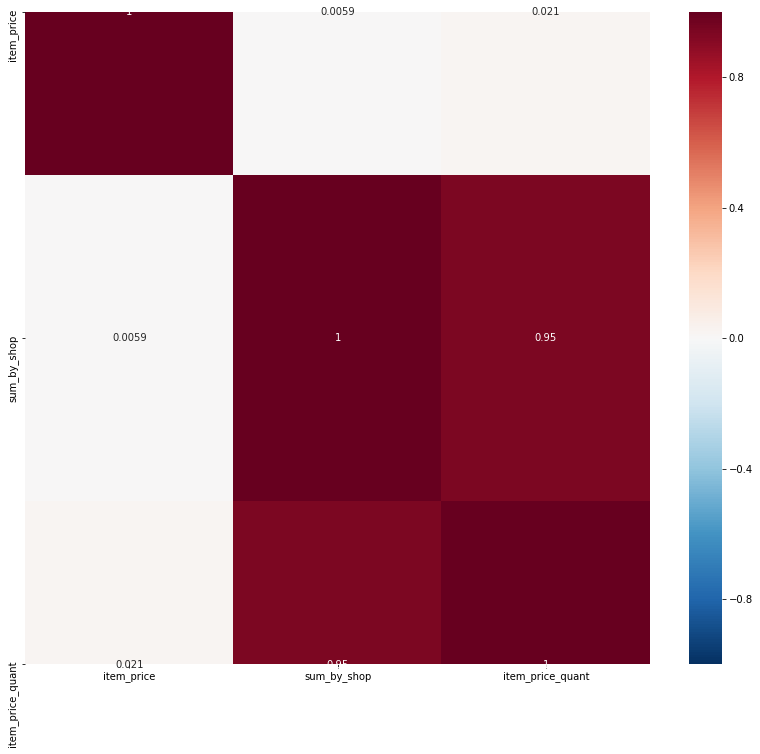

In [17]:
plt.figure(figsize=(14,12))
corr = data_df.corr()
sns.heatmap(corr, cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)